<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Binary Variational Semantic Hashing </h1>

<H3 align='center'> Extensión trabajo CIARP </H3>
<hr style="height:2px;border:none"/>

In [1]:
import numpy as np
import keras,gc, os, time, sys
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from scipy.special import expit

from base_networks import *
from utils import check_availability, load_imgs_mask

from utils import get_topK_labels,set_newlabel_list, enmask_data

np.random.seed(20)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmena/.local/lib/python3.5/site-package

In [2]:
!ls Data/VGG_128

ls: cannot access Data/VGG_128: No such file or directory


## Load Data

### MNIST
---

Imágenes en blanco y negro de 28x28 píxeles, de números del 0 al 9, que dan orígen a las 10 clases del problema.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|60000|10|
|Pruebas|10000|10|

In [15]:
name_dat = "MNIST-raw"

(X_t, aux_t), (X_test, aux_test) = keras.datasets.mnist.load_data()
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

X_t = np.concatenate([X_t, X_test], axis=0).reshape(len(labels_t),28*28)
X_t.shape

(70000, 784)

In [52]:
name_dat = "MNIST"

(_, aux_t), (_, aux_test) = keras.datasets.mnist.load_data()
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)

X_t = np.load("../AUX/VGG_128/mnist_VGG_avg.npy")

X_t.shape

(70000, 512)

### CIFAR-10
---
Imágenes RGB pequeñas de  32x32 píxeles, de fotos naturales de distintos objetos.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|50000|10|
|Pruebas|10000|10|

In [60]:
name_dat = "CIFAR-10"

(X_t, aux_t), (X_test, aux_test) = keras.datasets.cifar10.load_data()

labels = ["airplane", "automobile","bird", "cat","deer","dog","frog","horse","ship","truck"]
labels_t = np.asarray([labels[value[0]] for value in aux_t])
labels_test = np.asarray([labels[value[0]] for value in aux_test])
labels_t = np.concatenate((labels_t,labels_test),axis=0)


#X_t_input = np.load("../AUX/VGG_224/cifar10_VGG_avg.npy") #mejora
X_t_input = np.load("../AUX/VGG_128/cifar10_VGG.npy") #mejora
X_t_input = X_t_input.reshape(X_t_input.shape[0], np.prod(X_t_input.shape[1:]))

X_t = np.concatenate([X_t, X_test], axis=0)

X_t_input.shape

(60000, 8192)

### NUSWIDE
---
* Cantidad de datos totales: 269648
* Datos utlizados (con imagenes disponibles a descargar): 169500
* Datos top-21 clases: 158383

Imágenes de eventos con 81 tópicos asociados, re-dimensionadas a 64x64.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|81|
|Validación|xxx|81|
|Pruebas|xxx|81|

In [2]:
name_dat = "Nus-Wide"


mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

folder = "../Dataset_NUSWIDE/"
labels = pd.read_csv(folder+'Concepts81.txt',header=None).values.reshape(1,-1)[0]
print("Cantidad de labels: ",len(labels) )

labels_t = [[] for _ in range(269648)]
for concept in labels:
    aux = pd.read_csv(folder+"Groundtruth/AllLabels/Labels_"+concept+".txt",header=None)
    indexs_true = aux.loc[(aux==1).values[:,0]].index
    
    for value in indexs_true:
        labels_t[value].append(concept)
        
labels_t = enmask_data(labels_t, mask_av)
N_total = len(labels_t)
print("Cantidad de objetos: ",N_total )

labels_t[:5]

Cantidad de labels:  81
Cantidad de objetos:  169500


[['person'], ['person'], ['person'], ['person'], ['person']]

#### get top-K labels data

In [3]:
new_labels = get_topK_labels(labels_t, labels, K=21)

labels_t = set_newlabel_list(new_labels, labels_t)
labels = new_labels
# y si quedan datos sin clase?
mask_used_t = np.asarray(list(map(len,labels_t))) != 0

labels_t = enmask_data(labels_t, mask_used_t)
print("Cantidad de objetos: ", len(labels_t) )

category with most data (sky) has = 61066, the top-K category (mountain) has = 4232
Cantidad de objetos:  158383


N_used = 80*1000 #o 150k??
idx_all = np.arange(0, N_total)
mask_used = np.zeros(N_total, dtype=bool)
mask_used[np.random.choice(np.arange(0, N_total), size=N_used, replace=False)] = 1
mask_used

In [4]:
#X_t_input = np.load("../AUX/VGG_224/nuswide_VGG_avg.npy") #o flatten
X_t_input = np.load("../AUX/VGG_128/nuswide_VGG.npy") #o flatten
X_t_input = X_t_input.reshape(X_t_input.shape[0], np.prod(X_t_input.shape[1:]))


folder = "../Dataset_NUSWIDE/"
folder_imgs_name = folder+"small_images/"
list_images = pd.read_csv(folder+"ImageList/Imagelist_downloaded.txt", header=None).iloc[:,0]
imgs_files = [folder_imgs_name + value for value in list_images.values]
imgs_files = enmask_data(imgs_files, mask_av)

X_t = load_imgs_mask(imgs_files, mask_used_t, size=64) #images names to load
X_t.shape

El contador de lectura va en:  0
El contador de lectura va en:  10000
El contador de lectura va en:  20000
El contador de lectura va en:  30000
El contador de lectura va en:  40000
El contador de lectura va en:  50000
El contador de lectura va en:  60000
El contador de lectura va en:  70000
El contador de lectura va en:  80000
El contador de lectura va en:  90000
El contador de lectura va en:  100000
El contador de lectura va en:  110000
El contador de lectura va en:  120000
El contador de lectura va en:  130000
El contador de lectura va en:  140000
El contador de lectura va en:  150000
El contador de lectura va en:  160000


(158383, 64, 64, 3)

### CelebA
---
* Cantidad de datos totales: 202599
* Datos en plataforma Kaggle:https://www.kaggle.com/jessicali9530/celeba-dataset 

Imágenes RGB re-dimensionadas a 64x64 píxeles, de fotos naturales de rostros de celebridades. Una muestra es utilizada

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|40|
|Validación|xxx|40|
|Pruebas|xxx|40|

mask_av = check_availability(folder+"small_images/", labels_t)
np.savetxt("./Data/+"name_dat+"_mask_avail.txt", mask_av, fmt="%1i")

In [92]:
name_dat = "CelebA"
mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)

folder = "../CelebA/"

part = pd.read_csv(folder+"list_eval_partition.csv")
mask_train = (part["partition"].values == 0)[mask_av]
mask_val = (part["partition"].values == 1)[mask_av]
mask_test = (part["partition"].values == 2)[mask_av]

df_atrr = pd.read_csv(folder+"list_attr_celeba.csv")[mask_av]
img_names = df_atrr["image_id"].values
labels = list(df_atrr.columns[1:])
print("Cantidad de labels: ",len(labels) )

N_total = len(df_atrr)
print("Cantidad de objetos: ",N_total )
aux = (df_atrr == 1).values
labels_t = np.asarray([list(df_atrr.columns[aux[value]]) for value in range(N_total)])
labels[:5]

Cantidad de labels:  40
Cantidad de objetos:  202599


['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald']

In [93]:
X_t = np.load("./Data/VGG_128/celeba_VGG_avg.npy")
X_t.shape

(202599, 512)

### Validation creation

Pre-process: División por 255

In [5]:
##### 1000 imagenes de prueba... 
from utils import sample_test_mask
multi_l = not ("cifar-10" in name_dat.lower() or "mnist" in name_dat.lower())
mask_train = sample_test_mask(labels_t, N=100, multi_label=multi_l) #nuswide true

## creat test como dicen...
X_test_input = X_t_input[~mask_train]
X_test = X_t[~mask_train]
X_t_input = X_t_input[mask_train]
X_t = X_t[mask_train]


labels_test = enmask_data(labels_t, ~mask_train)
labels_t = enmask_data(labels_t, mask_train)

gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_t))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  156283
Cantidad de datos Pruebas:  2100


In [6]:
X_t = X_t.astype("float32")/255
X_test = X_test.astype("float32")/255
X_test

array([[[[0.6509804 , 0.68235296, 0.6627451 ],
         [0.6901961 , 0.7137255 , 0.69803923],
         [0.654902  , 0.6862745 , 0.6666667 ],
         ...,
         [0.5529412 , 0.4862745 , 0.40392157],
         [0.56078434, 0.4745098 , 0.40392157],
         [0.56078434, 0.48235294, 0.40392157]],

        [[0.6509804 , 0.6862745 , 0.6666667 ],
         [0.6745098 , 0.69803923, 0.6784314 ],
         [0.654902  , 0.6862745 , 0.6666667 ],
         ...,
         [0.5764706 , 0.49803922, 0.4117647 ],
         [0.5686275 , 0.4862745 , 0.4117647 ],
         [0.5568628 , 0.47843137, 0.40392157]],

        [[0.6431373 , 0.6784314 , 0.65882355],
         [0.7019608 , 0.72156864, 0.7058824 ],
         [0.6745098 , 0.7058824 , 0.6901961 ],
         ...,
         [0.56078434, 0.48235294, 0.4117647 ],
         [0.5686275 , 0.47843137, 0.40784314],
         [0.5529412 , 0.47058824, 0.4       ]],

        ...,

        [[0.3647059 , 0.36862746, 0.36862746],
         [0.3019608 , 0.30980393, 0.29803923]

In [7]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_t_input)

X_t_input = std.transform(X_t_input)
X_test_input = std.transform(X_test_input)
X_t_input

array([[-0.13542278,  4.288814  , -0.1818755 , ..., -0.17607836,
        -0.5141107 , -0.31419465],
       [-0.13542278, -0.12159236, -0.1818755 , ..., -0.17607836,
        -0.5141107 ,  1.0711929 ],
       [-0.13542278, -0.12159236, -0.1818755 , ..., -0.17607836,
        -0.5141107 , -0.31419465],
       ...,
       [-0.13542278, -0.12159236, -0.1818755 , ..., -0.17607836,
        -0.5141107 , -0.31419465],
       [-0.13542278, -0.12159236, -0.1818755 , ..., -0.17607836,
        -0.5141107 , -0.31419465],
       [-0.13542278, -0.12159236, -0.1818755 , ..., -0.17607836,
         2.8348794 , -0.31419465]], dtype=float32)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, X_train_input, X_val_input, labels_train, labels_val  = train_test_split(X_t, X_t_input, labels_t, random_state=20,test_size=len(X_test))

print("Cantidad de datos Entrenamiento: ",len(X_train))
print("Cantidad de datos Validación: ",len(X_val))
print("Cantidad de datos Pruebas: ",len(X_test))
del X_t, labels_t
gc.collect()

Cantidad de datos Entrenamiento:  154183
Cantidad de datos Validación:  2100
Cantidad de datos Pruebas:  2100


10

### Model Architecture
---
CNN
https://github.com/rtflynn/Cifar-Autoencoder

In [9]:
## GENERICO -- FOR ALL
aux_pre_E = define_pre_encoder(X_train_input.shape[1], layers=2,units=500,BN=True)
aux_pre_E.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               4096500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 4,351,000
Trainable params: 4,349,000
Non-trainable params: 2,000
_________________________________________________________________


In [22]:
layers = 3
filters = 64
_, shape = def_pre_encoder_CNN(X_train.shape[1:], 3, L=layers, filters=filters, activation='relu', strides=2 )

aux_G = define_generator_CNN(shape,3, L=layers, filters=filters,activation='relu',strides=2, BN=False, out_shape=X_train.shape[1:])
aux_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dummy_inp (InputLayer)       (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 16384)             32768     
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 32, 32, 128)       295040    
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 64, 64, 64)        73792     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 3)         1731      
Total para

In [12]:
def info_BKL_loss(logits_b):
    ep = K.epsilon()
    p_b_x = keras.activations.sigmoid(logits_b) #B_j = Q(b_j|x) probability of b_j
    p_b = K.mean(p_b_x, axis=0, keepdims=True) #marginalize over minibatch
    Nb = K.int_shape(p_b)[1]
    def infoKL(y_true, y_pred):
        return Nb*np.log(2) + K.sum( p_b*K.log(p_b + ep) + (1-p_b)* K.log(1-p_b +ep),axis=1)
    return infoKL


In [13]:
def REC_loss(x_true, x_pred):
    return K.mean( K.binary_crossentropy(x_true, x_pred), axis=(1,2,3))

import keras.backend as K
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)

def define_binary_VAE(q, p, Nb, opt='adam', beta=0., lamb=0.):
    tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3

    pre_encoder = keras.models.clone_model(q)
    generator = keras.models.clone_model(p, input_tensors=Input(shape=(Nb,)))
    generator.layers.pop(1) #remove old layers
    #print("pre-encoder network:")
    #pre_encoder.summary()
    #print("generator network:")
    #generator.summary()
    
    ## Encoder
    inp_shape = pre_encoder.input_shape[1:]
    x = Input(shape=inp_shape)
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)
                
    
    Recon_loss = REC_loss
    kl_loss = BKL_loss(logits_b)
    info_kl_loss = info_BKL_loss(logits_b) #over minibatch
    def BVAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred) + lamb*info_kl_loss(y_true,y_pred)
    
    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=BVAE_loss, metrics = [Recon_loss,kl_loss,info_kl_loss])
    
    return binary_vae, encoder, generator


### Train details
---

* 30* epochs* 
* *batch size* de 200
* optimizador Adam
* Inicializador de Glorot (para los pesos)

In [14]:
from utils import  compare_hist_train, add_hist_plot

batch_size = 100*2 #ya que son datasets mas grandes
epochs = 30 

In [13]:
#from utils import find_lambda

def create_model_B(lambda_V):
    return binary_VAE(X_train_input.shape[1],Nb=32,units=500,layers_e=2,layers_d=0
                                                                  ,beta=0, lamb=lambda_V, summ=False)

lambda_B = find_lambda(create_model_B, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=True, BS=batch_size)
#mnist -- raw







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
***************************************
*********** SUMMARY RESULTS ***********
***************************************


,lambda,score
0,1.000000e-07,0.8323
1,1.000000e-06,0.8339
2,1.000000e-05,0.8287
3,1.000000e-04,0.8317
4,1.000000e-03,0.8295
5,1.000000e-02,0.8371
6,1.000000e-01,0.8315
7,1.000000e+00,0.8198
8,1.000000e+01,0.7975
9,1.000000e+02,0.7293


Best value is 0.8371 with lambda 0.010000
Worst value is 0.5593 with lambda 10000.000000
***************************************


In [177]:
lambda_V_found = {"mnist-raw":1e-2, "mnist":1e-2, "cifar-10":1e1, "nus-wide":1e1} #values for sum

lambda_B = lambda_V_found[name_dat.lower()]
lambda_B

10.0

In [23]:
binary_vae,encoder_Bvae, beta_B = define_binary_VAE(aux_pre_E, aux_G, Nb=32, beta=0., lamb=0.)
binary_vae.summary()

hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val) )
                       #,callbacks=[Tau_Call(tau)] )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 8192)              0         
_________________________________________________________________
pre-encoder (Sequential)     (None, 500)               4351000   
_________________________________________________________________
logits-b (Dense)             (None, 32)                16032     
_________________________________________________________________
sampled (Lambda)             (None, 32)                0         
_________________________________________________________________
generator/decoder (Model)    (None, 64, 64, 3)         1501315   
Total params: 5,868,347
Trainable params: 5,866,347
Non-trainable params: 2,000
_________________________________________________________________
Train on 154183 samples, validate on 2100 samples
Epoch 1/30
154183/154183 [==============================] - 72s - loss: 0.6217

In [24]:
def show_reconstruct(X_inp, X, model, low_error=False):
    n = 8
    
    X_hat = model.predict(X_inp)
    idxs = np.arange(len(X))
    if low_error:
        error = np.mean(-X*np.log(X_hat) -(1-X)*np.log(1-X_hat), axis=(1,2,3))
        #values = np.argsort(error)[:n]
        #print(np.sort(error)[:n])
    

    if low_error:
        v = np.mean(error) - 1*np.std(error)
        n_sampleds = np.random.choice( idxs[error < v], size=n, replace=False)
    else:
        n_sampleds = np.random.choice( idxs, size=n, replace=False)
            
    plt.figure(figsize=(20, 4))
    for i,n_i in enumerate(n_sampleds):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(np.squeeze(X[n_i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Imagenes reales")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.squeeze(X_hat[n_i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruccion")
    plt.show()

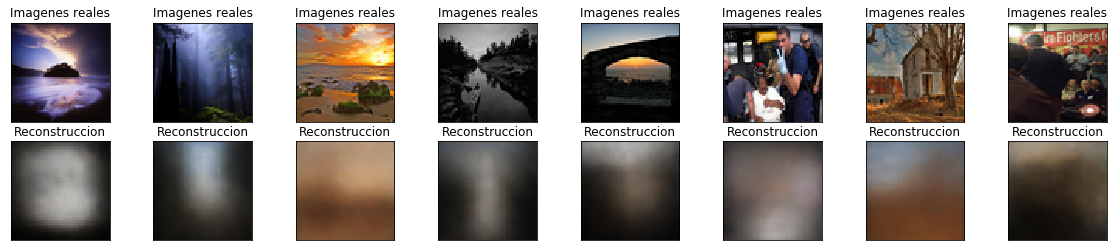

In [25]:
show_reconstruct(X_test_input, X_test, binary_vae)

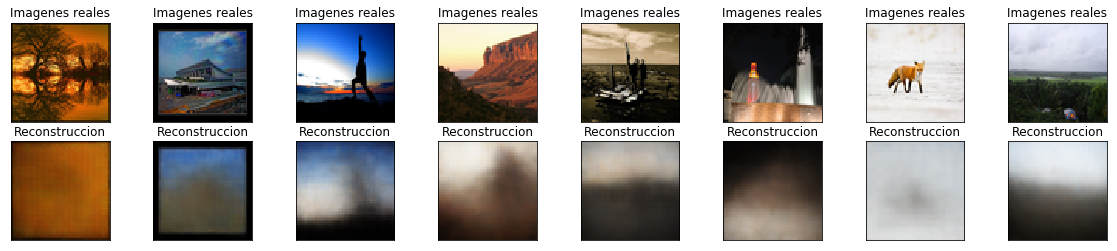

In [26]:
show_reconstruct(X_test_input, X_test, binary_vae, low_error=True)

### Another intrinsic measure: *Classification*


In [13]:
#function to define and train model
from sklearn.metrics import jaccard_score
from utils import define_fit, MedianHashing, visualize_probas, visualize_mean, calculate_hash,visualize_probas_byB

results = []
results_S = []
results_B = []
results_O_B = [] #original testing on tresholded

In [119]:
#codify input data (binarize -- or aprox)
X_train_logits = encoder_Bvae.predict(X_train_input)
X_val_logits = encoder_Bvae.predict(X_test_input)

#probabilities
X_train_Bcode = expit(X_train_logits)
X_val_Bcode = expit(X_val_logits)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    inputs = np.asarray(inputs)
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list or type(aux_labels) == np.ndarray :
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_train)
#C_val = codify_labels(labels_val)
C_val = codify_labels(labels_test)
C_train

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

MNIST-raw


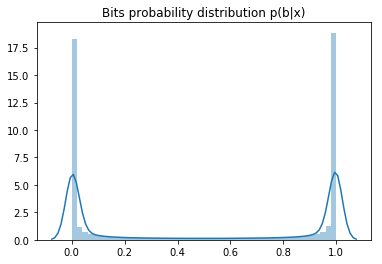

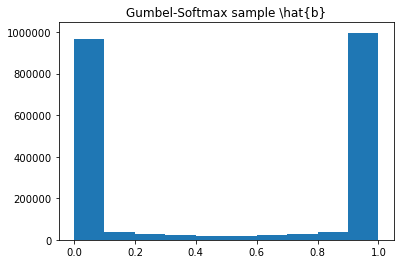

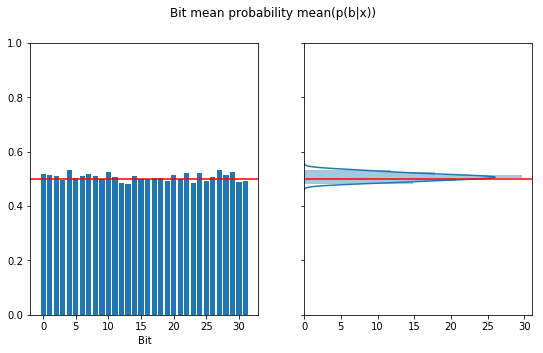

In [27]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

MNIST


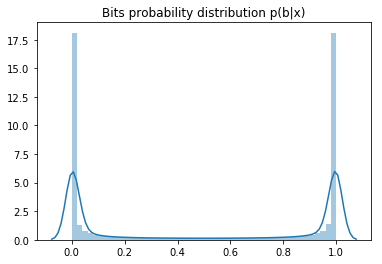

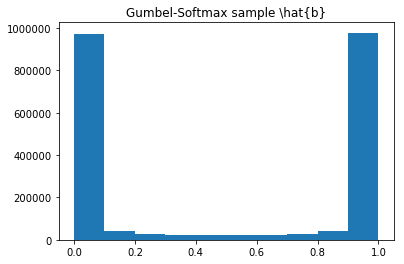

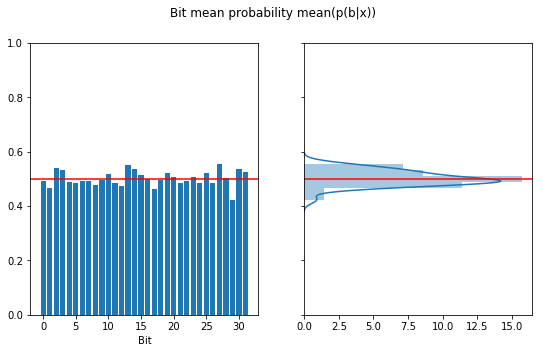

In [65]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

CIFAR-10


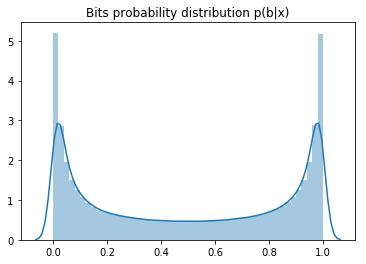

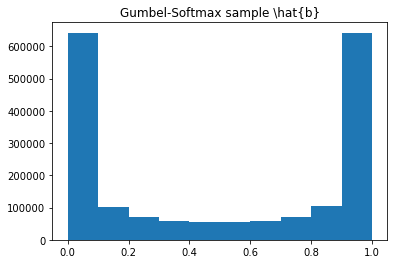

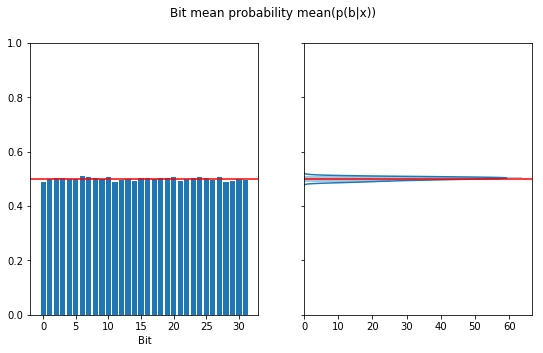

In [88]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

Nus-Wide


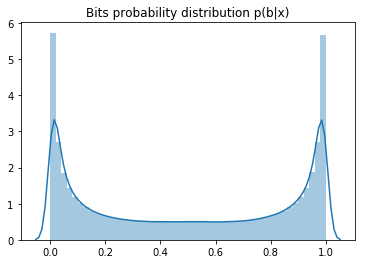

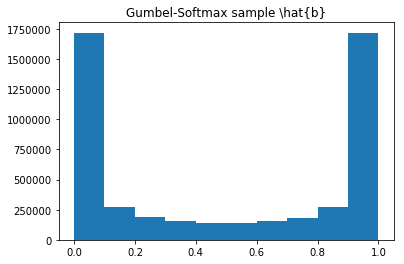

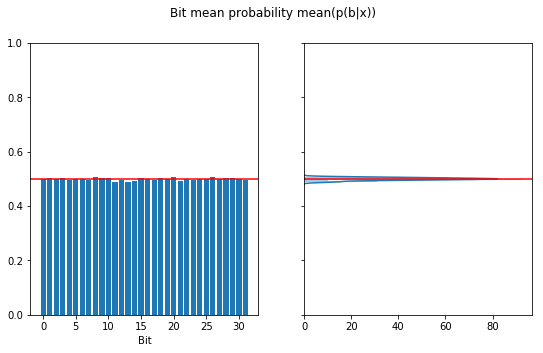

In [120]:
print(name_dat)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

In [121]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1_O = define_fit(multi_label,X_train_Bcode,C_train)

if not multi_label:
    aux.append(model1_O.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

Done


In [122]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Binary VAE (train-val): %f - %f"%(valores[1],valores[2]))


Accuracy on dataset:  mnist-raw
Binary VAE (train-val): 0.966176 - 0.949000

Accuracy on dataset:  mnist
Binary VAE (train-val): 0.945735 - 0.930000

Accuracy on dataset:  cifar-10
Binary VAE (train-val): 0.802500 - 0.784000

Accuracy on dataset:  nus-wide
Binary VAE (train-val): 0.520555 - 0.487564


In [123]:
## binary // treshold it
X_train_Bcode_B = calculate_hash(X_train_Bcode, from_probas=True, from_logits=False)
X_val_Bcode_B = calculate_hash(X_val_Bcode, from_probas=True, from_logits=False)

X_train_Bcode_B

array([[1, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int32)

In [124]:
### trained models over encoder representation testing on tresholded representation (see how decrease)
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

if not multi_label:
    aux.append(model1_O.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_O_B.append(aux)
print("Done")

Done


In [125]:
print("Classification on Binary (thresholded) representation")
for valores in results_O_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Binary VAE (train-val): %f - %f"%(valores[1],valores[2]))

Classification on Binary (thresholded) representation

Accuracy on dataset:  mnist-raw
Binary VAE (train-val): 0.939735 - 0.930000

Accuracy on dataset:  mnist
Binary VAE (train-val): 0.925176 - 0.918000

Accuracy on dataset:  cifar-10
Binary VAE (train-val): 0.706569 - 0.692000

Accuracy on dataset:  nus-wide
Binary VAE (train-val): 0.445007 - 0.403894


In [126]:
aux = [name_dat.lower()]
multi_label = "celeba" in aux or "nus-wide" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)

if not multi_label:
    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

Done


In [127]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Binary VAE (train-val): %f - %f"%(valores[1],valores[2]))

Classification on Binary representation

Accuracy on dataset:  mnist-raw
Binary VAE (train-val): 0.950191 - 0.928000

Accuracy on dataset:  mnist
Binary VAE (train-val): 0.932059 - 0.914000

Accuracy on dataset:  cifar-10
Binary VAE (train-val): 0.735569 - 0.721000

Accuracy on dataset:  nus-wide
Binary VAE (train-val): 0.463491 - 0.414434




### Results
---

In [ ]:
from utils import MedianHashing, get_similar, measure_metrics, calculate_hash
from utils import MAP_atk, M_P_atk, AP_atk

### Experimentación
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [37]:
def evaluate_hashingB(encoder,train,val,labels_train,labels_val,traditional=True,tipo="topK",K=100):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    
    train_hash = calculate_hash(encode_train, from_probas=~traditional )
    val_hash = calculate_hash(encode_val, from_probas=~traditional)

    val_similares_train =  get_similar(val_hash, train_hash, tipo=tipo,K=K) 

    return measure_metrics(labels,val_similares_train,labels_query=labels_val,labels_source=labels_train)


### Experimentando variando el #Bits

In [38]:
binary_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},
              "celeba":{"p":[],"r":[]},'nus-wide':{"p":[],"r":[]},
               "mnist-raw":{"p":[],"r":[]}}

In [128]:
Nbits = np.asarray([4,8,16,32,64])
dataset = name_dat.lower()

for Nbit in Nbits:    
    binary_vae,encoder_Bvae,generator_Bvae= binary_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=0,lamb=lambda_B)
    hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size, verbose=0
                           ,validation_data=(X_val_input,X_val) )
    p_b,r_b = evaluate_hashingB(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
    del binary_vae, encoder_Bvae, generator_Bvae
    keras.backend.clear_session()
    gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500)               2000      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

In [129]:
print("Resultados de Precision en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["MNIST-R"] = binary_dat["mnist-raw"]["p"]
t["MNIST"] = binary_dat["mnist"]["p"]
t["CIFAR-10"] = binary_dat["cifar-10"]["p"]
t["Nus-Wide"] = binary_dat["nus-wide"]["p"]
print("\n*** VAE Binary***")
print(t.T)

print("\nResultados de Recall en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["MNIST-R"] = binary_dat["mnist-raw"]["r"]
t["MNIST"] = binary_dat["mnist"]["r"]
t["CIFAR-10"] = binary_dat["cifar-10"]["r"]
t["Nus-Wide"] = binary_dat["nus-wide"]["r"]
print("\n*** VAE Binary***")
print(t.T)

Resultados de Precision en validación

*** VAE Binary***
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
MNIST-R   0.353940  0.588640   0.752460   0.831430   0.876010
MNIST     0.410840  0.640680   0.767750   0.842960   0.857640
CIFAR-10  0.316370  0.437620   0.480330   0.534860   0.583710
Nus-Wide  0.607862  0.656805   0.712305   0.752062   0.770952

Resultados de Recall en validación

*** VAE Binary***
                 0         1          2          3          4
N bits    4.000000  8.000000  16.000000  32.000000  64.000000
MNIST-R   0.005106  0.008592   0.010994   0.012177   0.012842
MNIST     0.006048  0.009373   0.011278   0.012409   0.012635
CIFAR-10  0.005455  0.007546   0.008282   0.009223   0.010065
Nus-Wide  0.001309  0.001507   0.001700   0.001846   0.001921


## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil *tokens* más frecuentes y *Term Frequency*

In [40]:
from utils import calculate_hash
def evaluate_hashing_DE(train_hash,test_hash,labels_trainn,labels_testt,tipo="topK",eval_tipo='PRatk',K=100):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    test_similares_train =  get_similar(test_hash,train_hash,tipo=tipo,K=K)
    if eval_tipo=="MAP":
        return MAP_atk(test_similares_train,labels_query=labels_testt, labels_source=labels_trainn, K=0) #all ranking
    elif eval_tipo == "PRatk":
        return measure_metrics(labels,test_similares_train,labels_testt,labels_source=labels_trainn)
    elif eval_tipo == "Patk":
        return M_P_atk(test_similares_train, labels_query=labels_testt, labels_source=labels_trainn, K=K)

def hash_data(model, x_train, x_test, binary=True):
    encode_train = model.predict(x_train)
    encode_test = model.predict(x_test)
    
    train_hash = calculate_hash(encode_train, from_probas=binary )
    test_hash = calculate_hash(encode_test, from_probas = binary)
    return train_hash, test_hash

#to save results
results_dat = {"mnist":{},"mnist-raw":{},"cifar-10":{},"celeba":{}, "nus-wide":{}} 

BITS_S = 32

In [178]:
X_total = np.concatenate((X_train,X_val),axis=0)
X_total_input = X_total
labels_total = np.concatenate((labels_train,labels_val),axis=0)
del X_train, X_train_input, X_val, X_val_input, labels_train,labels_val
gc.collect()

0

In [179]:
binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_total.shape[1],Nb=BITS_S,units=500,layers_e=2,layers_d=0,beta=0,lamb=lambda_B)
binary_vae.fit(X_total_input, X_total, epochs=epochs, batch_size=batch_size,verbose=0)
#save model
encoder_Bvae.save("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_VGG_L?avg.h5")
generator_Bvae.save_weights("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_VGG_L?avg_w.h5")

keras.backend.clear_session()
gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               256500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
Total params: 511,000
Trainable params: 509,000
Non-trainable params: 2,000
_________________________________________________________________
generator network:
_________________________________________________________________
Layer (type)              

101117

In [180]:
##load model
encoder_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_VGG_L?avg.h5")
#generator_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN.h5")
encoder_Bvae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 500)               511000    
_________________________________________________________________
logits-b (Dense)             (None, 32)                16032     
Total params: 527,032
Trainable params: 525,032
Non-trainable params: 2,000
_________________________________________________________________


/home/fmena/.local/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [181]:
total_hash_BVAE, test_hash_BVAE = hash_data(encoder_Bvae,X_total_input,X_test_input)

del X_total_input, X_test_input, X_test, X_total
gc.collect()

keras.backend.clear_session()
gc.collect()

0

In [182]:
dataset = name_dat.lower()

p_b,r_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,tipo="topK")
results_dat[dataset]["p"] = [p_b]
results_dat[dataset]["r"] = [r_b]
p5k_b = evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="Patk",K=5000)
results_dat[dataset]["p5k"] = [p5k_b]

print("Realizado.")

Realizado.


In [135]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = pd.DataFrame() #Table()
t["Modelo"] = ["Binario"]
t["MNIST-R"] = results_dat["mnist-raw"]["p"]
t["MNIST"] = results_dat["mnist"]["p"]
t["CIFAR-10"] = results_dat["cifar-10"]["p"]
#t["CelebA"] = results_dat["celeba"]["p"]
t["Nus-Wide"] = results_dat["nus-wide"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = pd.DataFrame() #Table()
t["Modelo"] = ["Binario"]
t["MNIST-R"] = results_dat["mnist-raw"]["r"]
t["MNIST"] = results_dat["mnist"]["r"]
t["CIFAR-10"] = results_dat["cifar-10"]["r"]
#t["CelebA"] = results_dat["celeba"]["r"]
t["Nus-Wide"] = results_dat["nus-wide"]["r"]
print(t)

print("\n\nResultados de Precision en pruebas (top-5k)")
t = pd.DataFrame() #Table()
t["Modelo"] = ["Binario"]
t["MNIST-R"] = results_dat["mnist-raw"]["p5k"]
t["MNIST"] = results_dat["mnist"]["p5k"]
t["CIFAR-10"] = results_dat["cifar-10"]["p5k"]
#t["CelebA"] = results_dat["celeba"]["p5k"]
t["Nus-Wide"] = results_dat["nus-wide"]["p5k"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas
    Modelo  MNIST-R    MNIST  CIFAR-10  Nus-Wide
0  Binario  0.83594  0.83917   0.55452  0.780357


Resultados de Recall en pruebas
    Modelo   MNIST-R     MNIST  CIFAR-10  Nus-Wide
0  Binario  0.012112  0.012168  0.009399  0.001605


Resultados de Precision en pruebas (top-5k)
    Modelo   MNIST-R     MNIST  CIFAR-10  Nus-Wide
0  Binario  0.460572  0.580414  0.353221   0.70223


In [51]:
print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)
#raw estilo binary..

MAP on MNIST-raw dataset
Binary VAE =  0.39954319670749655


In [79]:
print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on MNIST dataset
Binary VAE =  0.5284321856135851


In [102]:
print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on CIFAR-10 dataset
Binary VAE =  0.3174797038432593


In [183]:
print("MAP on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=9999999)
print("Binary VAE = ",map_b)

MAP on Nus-Wide dataset
Binary VAE =  0.5390597349718573


In [184]:
print("MAP@5000 on %s dataset"%name_dat)
map_b= evaluate_hashing_DE(total_hash_BVAE, test_hash_BVAE,labels_total,labels_test,eval_tipo="MAP",K=5000)
print("Binary VAE = ",map_b)

MAP@5000 on Nus-Wide dataset
Binary VAE =  0.7393195512917352


In [ ]:
## en otro jupyter agregar varios..

La propuesta presentada de *VAE* binario sobrepasa al *VAE* tradicional en todos los resultados presentados.
### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

In [33]:
from utils import get_similar_hammD_based,get_hammD
ball_radius = np.arange(0,25) #ball of radius graphic

traditional_dat_BS = {"mnist":{},"cifar-10":{},"celeba":{},'nus-wide':{},"mnist-raw":{}}
binary_dat_BS = {"mnist":{},"cifar-10":{},"celeba":{},'nus-wide':{},"mnist-raw":{}}

In [ ]:
dat_show = "MNIST"
print("DAtaset ",dat_show)
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

In [ ]:
dat_show = "CIFAR-10"
print("DAtaset ",dat_show)
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

In [ ]:
dat_show = "NUS-WIDE"
print("DAtaset ",dat_show)
print("B-VAE P@ball=2 equals=",binary_dat_BS[dat_show.lower()]["p"][2])

In [111]:
%%time
dataset = name_dat.lower()

binary_dat_BS[dataset]["p"] = []
binary_dat_BS[dataset]["r"] = []

hammD_scores = get_hammD(test_hash_BVAE,total_hash_BVAE) #all hamming ranking
for ball_r in ball_radius:
    test_similares_train = get_similar_hammD_based(hammD_scores,tipo="ball", ball=ball_r)

    p_b,r_b  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    binary_dat_BS[dataset]["p"].append(p_b)
    binary_dat_BS[dataset]["r"].append(r_b)


del hammD_scores, test_similares_train
gc.collect()
    
print("Termino")

Termino
CPU times: user 1h 55min 16s, sys: 2min 51s, total: 1h 58min 8s
Wall time: 1h 58min 9s


In [ ]:
choosed_data = ["MNIST-RAW", "MNIST", "CIFAR-10", "NUS-WIDE"]
f, axx = plt.subplots(1, len(choosed_data), figsize=(20,5), sharey=False)

b_aux = 16
for z in range(len(choosed_data)):
    dat = choosed_data[z].lower()

    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["p"][:b_aux],'go-',label="precision (Binary VAE)")
    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["r"][:b_aux],'gv-', label='recall' ) 
    axx[z].set_title(choosed_data[z])
    axx[z].set_xticks(ball_radius)
    axx[z].set_xlabel("Ball radius")
    axx[z].set_xlim(-0.5, len(ball_radius[:b_aux])-.5)
    #axx[z].set_ylim(-0.05)
    
    if z == 0:
        axx[z].set_ylabel("Score")
        axx[z].legend(bbox_to_anchor=(2, -0.1))
        
f.suptitle("Comparison of ball search")
plt.show()

In [ ]:
### donde beta esta calculado guardad...